# JAX vs. Nabla: Training an MLP

This notebook provides a thorough comparison between Nabla and JAX for training an MLP to learn a complex 8-period sine function. We compare:

1. Different execution modes (eager vs JIT)
2. Performance characteristics
3. Final accuracy
4. Numerical precision handling

**Problem**: Train an MLP to learn `f(x) = sin(8 * 2π * x) / 2 + 0.5` - a complex high-frequency sine function.

**Key Focus**: Ensure fair comparison by using consistent float32 precision across both frameworks.

In [1]:
# Installation and imports
import os
import sys
import time

# Force JAX to use CPU - Commment this out to use GPU in JAX !!!
os.environ["JAX_PLATFORMS"] = "cpu"

IN_COLAB = "google.colab" in sys.modules

try:
    import jax
    import jax.numpy as jnp
    import matplotlib.pyplot as plt
    import numpy as np
    from jax import jit, value_and_grad

    import nabla as nb
except ImportError:
    import subprocess

    # Install required packages
    packages = ["jax", "jaxlib", "matplotlib", "numpy", "nabla-ml"]
    subprocess.run([sys.executable, "-m", "pip", "install"] + packages, check=True)

    # Re-import after installation
    import jax
    import jax.numpy as jnp
    import matplotlib.pyplot as plt
    import numpy as np
    from jax import jit, value_and_grad

    import nabla as nb

# Verify the backends
print(f"JAX default backend: {jax.default_backend()}")

print(
    f"🎉 All libraries loaded successfully! Python {sys.version_info.major}.{sys.version_info.minor}"
)

JAX default backend: cpu
🎉 All libraries loaded successfully! Python 3.10


In [2]:
# Configuration parameters
BATCH_SIZE = 128
LAYERS = [1, 256, 1024, 2048, 2048, 1024, 64, 1]  # MLP architecture
LEARNING_RATE = 0.001
NUM_EPOCHS = 1000
PRINT_INTERVAL = 100
SIN_PERIODS = 8
GLOBAL_SEED = 42
np.random.seed(GLOBAL_SEED)

## 2. Core Model Functions (Nabla and JAX)

In [3]:
# ===== Shared Data Generation =====
def create_sin_dataset(batch_size: int = BATCH_SIZE) -> tuple[np.ndarray, np.ndarray]:
    """Generate training data for the sinusoidal function using NumPy."""
    x_np = np.random.uniform(0.0, 1.0, size=(batch_size, 1)).astype(np.float32)
    targets_np = (np.sin(SIN_PERIODS * 2.0 * np.pi * x_np) / 2.0 + 0.5).astype(
        np.float32
    )
    return x_np, targets_np


# ===== Nabla Implementation =====
def nb_mlp_forward(x: nb.Array, params: list[nb.Array]) -> nb.Array:
    """Forward pass of the MLP with ReLU activations (Nabla)."""
    output = x
    for i in range(0, len(params) - 1, 2):
        w, b = params[i], params[i + 1]
        output = nb.matmul(output, w) + b
        if i < len(params) - 2:  # No ReLU for the output layer
            output = nb.relu(output)
    return output


def nb_mean_squared_error(predictions: nb.Array, targets: nb.Array) -> nb.Array:
    """Compute mean squared error loss (Nabla)."""
    diff = predictions - targets
    squared_errors = diff * diff
    batch_size = nb.array(predictions.shape[0], dtype=nb.DType.float32)
    return nb.sum(squared_errors) / batch_size


def nb_create_sin_dataset(batch_size: int = BATCH_SIZE) -> tuple[nb.Array, nb.Array]:
    """Generate training data for the sinusoidal function (Nabla)."""
    x_np, targets_np = create_sin_dataset(batch_size)
    x = nb.Array.from_numpy(x_np)
    targets = nb.Array.from_numpy(targets_np)
    return x, targets


def nb_initialize_for_complex_function(
    layers: list[int], seed: int = GLOBAL_SEED
) -> list[nb.Array]:
    """Initialize weights using He Normal initialization (Nabla)."""
    np.random.seed(seed)
    params = []
    for i in range(len(layers) - 1):
        fan_in, fan_out = layers[i], layers[i + 1]
        std = (2.0 / fan_in) ** 0.5
        w_np = std * np.random.normal(size=(fan_in, fan_out)).astype(np.float32)
        b_np = np.zeros((fan_out,), dtype=np.float32)
        w = nb.Array.from_numpy(w_np)
        b = nb.Array.from_numpy(b_np)
        params.extend([w, b])
    return params


# ===== JAX Implementation =====
def jax_mlp_forward(x: jnp.ndarray, params: list[jnp.ndarray]) -> jnp.ndarray:
    """Forward pass of the MLP with ReLU activations (JAX)."""
    output = x
    for i in range(0, len(params) - 1, 2):
        w, b = params[i], params[i + 1]
        output = jnp.matmul(output, w) + b
        if i < len(params) - 2:  # No ReLU for the output layer
            output = jax.nn.relu(output)
    return output


def jax_mean_squared_error(
    predictions: jnp.ndarray, targets: jnp.ndarray
) -> jnp.ndarray:
    """Compute mean squared error loss (JAX)."""
    diff = predictions - targets
    squared_errors = diff * diff
    batch_size = jnp.array(predictions.shape[0], dtype=jnp.float32)
    return jnp.sum(squared_errors) / batch_size


def jax_create_sin_dataset(
    batch_size: int = BATCH_SIZE,
) -> tuple[jnp.ndarray, jnp.ndarray]:
    """Generate training data for the sinusoidal function (JAX)."""
    x_np, targets_np = create_sin_dataset(batch_size)
    x = jnp.array(x_np)
    targets = jnp.array(targets_np)
    return x, targets


def jax_initialize_for_complex_function(
    layers: list[int], seed: int = GLOBAL_SEED
) -> list[jnp.ndarray]:
    """Initialize weights using He Normal initialization (JAX)."""
    np.random.seed(seed)
    params = []
    for i in range(len(layers) - 1):
        fan_in, fan_out = layers[i], layers[i + 1]
        std = (2.0 / fan_in) ** 0.5
        w_np = std * np.random.normal(size=(fan_in, fan_out)).astype(np.float32)
        b_np = np.zeros((fan_out,), dtype=np.float32)
        w = jnp.array(w_np)
        b = jnp.array(b_np)
        params.extend([w, b])
    return params

## 3. Optimizer Implementations (Nabla and JAX)

In [4]:
# ===== Shared Optimizer Implementation =====
def adamw_step(
    params: list,
    gradients: list,
    m_states: list,
    v_states: list,
    step: int,
    learning_rate: float = LEARNING_RATE,
    beta1: float = 0.9,
    beta2: float = 0.999,
    eps: float = 1e-8,
    weight_decay: float = 0.01,
) -> tuple[list, list, list]:
    """Shared AdamW optimization step with weight decay."""
    updated_params = []
    updated_m = []
    updated_v = []
    bc1, bc2 = 1.0 - beta1**step, 1.0 - beta2**step

    for param, grad, m, v in zip(params, gradients, m_states, v_states, strict=False):
        new_m = beta1 * m + (1.0 - beta1) * grad
        new_v = beta2 * v + (1.0 - beta2) * (grad * grad)
        m_corrected = new_m / bc1
        v_corrected = new_v / bc2
        update = m_corrected / (v_corrected**0.5 + eps) + weight_decay * param
        new_param = param - learning_rate * update
        updated_params.append(new_param)
        updated_m.append(new_m)
        updated_v.append(new_v)

    return updated_params, updated_m, updated_v


def init_adamw_state(params: list) -> tuple[list, list]:
    """Shared function to initialize AdamW optimizer states."""
    # Create empty arrays with the same shape as params
    if isinstance(params[0], nb.Array):
        m_states = [nb.zeros_like(param) for param in params]
        v_states = [nb.zeros_like(param) for param in params]
    else:
        m_states = [jnp.zeros_like(param) for param in params]
        v_states = [jnp.zeros_like(param) for param in params]
    return m_states, v_states


# ===== Nabla Optimizer =====
def nb_adamw_step(
    params: list[nb.Array],
    gradients: list[nb.Array],
    m_states: list[nb.Array],
    v_states: list[nb.Array],
    step: int,
    learning_rate: float = LEARNING_RATE,
    beta1: float = 0.9,
    beta2: float = 0.999,
    eps: float = 1e-8,
    weight_decay: float = 0.01,
) -> tuple[list[nb.Array], list[nb.Array], list[nb.Array]]:
    """AdamW optimization step with weight decay (Nabla)."""
    return adamw_step(
        params,
        gradients,
        m_states,
        v_states,
        step,
        learning_rate,
        beta1,
        beta2,
        eps,
        weight_decay,
    )


def nb_init_adamw_state(
    params: list[nb.Array],
) -> tuple[list[nb.Array], list[nb.Array]]:
    """Initialize AdamW optimizer states (Nabla)."""
    return init_adamw_state(params)


# ===== JAX Optimizer =====
def jax_adamw_step(
    params: list[jnp.ndarray],
    gradients: list[jnp.ndarray],
    m_states: list[jnp.ndarray],
    v_states: list[jnp.ndarray],
    step: int,
    learning_rate: float = LEARNING_RATE,
    beta1: float = 0.9,
    beta2: float = 0.999,
    eps: float = 1e-8,
    weight_decay: float = 0.01,
) -> tuple[list[jnp.ndarray], list[jnp.ndarray], list[jnp.ndarray]]:
    """AdamW optimization step with weight decay (JAX)."""
    return adamw_step(
        params,
        gradients,
        m_states,
        v_states,
        step,
        learning_rate,
        beta1,
        beta2,
        eps,
        weight_decay,
    )


def jax_init_adamw_state(
    params: list[jnp.ndarray],
) -> tuple[list[jnp.ndarray], list[jnp.ndarray]]:
    """Initialize AdamW optimizer states (JAX)."""
    return init_adamw_state(params)

## 4. Training Step Implementations

In [5]:
# ===== Nabla Training Steps =====
def nb_train_step_no_jit(
    x: nb.Array,
    targets: nb.Array,
    params: list[nb.Array],
    m_states: list[nb.Array],
    v_states: list[nb.Array],
    step: int,
    learning_rate: float,
) -> tuple[list[nb.Array], list[nb.Array], list[nb.Array], nb.Array]:
    """Training step in eager mode (Nabla - no JIT)."""
    loss_value, param_gradients = nb.value_and_grad(
        lambda *p: nb_mean_squared_error(nb_mlp_forward(x, p), targets),
        argnums=list(range(len(params))),
    )(*params)

    updated_params, updated_m, updated_v = nb_adamw_step(
        params, param_gradients, m_states, v_states, step, learning_rate
    )

    return updated_params, updated_m, updated_v, loss_value


@nb.djit
def nb_train_step_djit(
    x: nb.Array,
    targets: nb.Array,
    params: list[nb.Array],
    m_states: list[nb.Array],
    v_states: list[nb.Array],
    step: int,
    learning_rate: float,
) -> tuple[list[nb.Array], list[nb.Array], list[nb.Array], nb.Array]:
    """Training step with dynamic JIT (Nabla)."""
    loss_value, param_gradients = nb.value_and_grad(
        lambda *p: nb_mean_squared_error(nb_mlp_forward(x, p), targets),
        argnums=list(range(len(params))),
    )(*params)

    updated_params, updated_m, updated_v = nb_adamw_step(
        params, param_gradients, m_states, v_states, step, learning_rate
    )

    return updated_params, updated_m, updated_v, loss_value


@nb.jit
def nb_train_step_jit(
    x: nb.Array,
    targets: nb.Array,
    params: list[nb.Array],
    m_states: list[nb.Array],
    v_states: list[nb.Array],
    step: int,
    learning_rate: float,
) -> tuple[list[nb.Array], list[nb.Array], list[nb.Array], nb.Array]:
    """Training step with static JIT (Nabla)."""
    loss_value, param_gradients = nb.value_and_grad(
        lambda *p: nb_mean_squared_error(nb_mlp_forward(x, p), targets),
        argnums=list(range(len(params))),
    )(*params)

    updated_params, updated_m, updated_v = nb_adamw_step(
        params, param_gradients, m_states, v_states, step, learning_rate
    )

    return updated_params, updated_m, updated_v, loss_value


# ===== JAX Training Steps =====
def jax_train_step_no_jit(
    x: jnp.ndarray,
    targets: jnp.ndarray,
    params: list[jnp.ndarray],
    m_states: list[jnp.ndarray],
    v_states: list[jnp.ndarray],
    step: int,
    learning_rate: float,
) -> tuple[list[jnp.ndarray], list[jnp.ndarray], list[jnp.ndarray], jnp.ndarray]:
    """Training step in eager mode (JAX - no JIT)."""

    def loss_fn(params_inner):
        predictions = jax_mlp_forward(x, params_inner)
        return jax_mean_squared_error(predictions, targets)

    loss_value, param_gradients = value_and_grad(loss_fn)(params)

    updated_params, updated_m, updated_v = jax_adamw_step(
        params, param_gradients, m_states, v_states, step, learning_rate
    )

    return updated_params, updated_m, updated_v, loss_value


@jit
def jax_train_step_jit(
    x: jnp.ndarray,
    targets: jnp.ndarray,
    params: list[jnp.ndarray],
    m_states: list[jnp.ndarray],
    v_states: list[jnp.ndarray],
    step: int,
    learning_rate: float,
) -> tuple[list[jnp.ndarray], list[jnp.ndarray], list[jnp.ndarray], jnp.ndarray]:
    """Training step with JIT (JAX)."""

    def loss_fn(params_inner):
        predictions = jax_mlp_forward(x, params_inner)
        return jax_mean_squared_error(predictions, targets)

    loss_value, param_gradients = value_and_grad(loss_fn)(params)

    updated_params, updated_m, updated_v = jax_adamw_step(
        params, param_gradients, m_states, v_states, step, learning_rate
    )

    return updated_params, updated_m, updated_v, loss_value

## 5. Experiment Runner Functions

In [6]:
def run_nabla_experiment(train_step_func, jit_mode: str):
    """Run training experiment with Nabla."""
    print(f"\n{'=' * 50}\nStarting Nabla Training with: {jit_mode}\n{'=' * 50}")
    print(f"Architecture: {LAYERS}")
    print(f"Initial Learning Rate: {LEARNING_RATE}")

    # Initialize model and optimizer
    params = nb_initialize_for_complex_function(LAYERS, seed=GLOBAL_SEED)
    m_states, v_states = nb_init_adamw_state(params)

    # Initial evaluation
    x_init, targets_init = nb_create_sin_dataset(BATCH_SIZE)
    predictions_init = nb_mlp_forward(x_init, params)
    initial_loss = (
        nb_mean_squared_error(predictions_init, targets_init).to_numpy().item()
    )
    print(f"Initial Loss: {initial_loss:.6f}")

    # Training loop
    avg_loss, total_time, compile_time = 0.0, 0.0, 0.0
    print("Starting training loop...")

    for epoch in range(1, NUM_EPOCHS + 1):
        epoch_start = time.time()
        current_lr = LEARNING_RATE * (0.95 ** (epoch // 1000))
        x, targets = nb_create_sin_dataset(BATCH_SIZE)

        if "JIT" in jit_mode and epoch == 1:
            compile_start = time.time()
            updated_params, updated_m, updated_v, loss_value = train_step_func(
                x, targets, params, m_states, v_states, epoch, current_lr
            )
            compile_time = time.time() - compile_start
        else:
            updated_params, updated_m, updated_v, loss_value = train_step_func(
                x, targets, params, m_states, v_states, epoch, current_lr
            )

        params, m_states, v_states = updated_params, updated_m, updated_v
        avg_loss += loss_value.to_numpy().item()
        total_time += time.time() - epoch_start

        if epoch % PRINT_INTERVAL == 0:
            print(f"Epoch {epoch:4d} | Avg Loss: {avg_loss / PRINT_INTERVAL:.6f}")
            avg_loss = 0.0

    # Final evaluation
    x_test = nb.Array.from_numpy(
        np.linspace(0, 1, 1000).reshape(-1, 1).astype(np.float32)
    )
    targets_test = nb.Array.from_numpy(
        (np.sin(SIN_PERIODS * 2.0 * np.pi * x_test.to_numpy()) / 2.0 + 0.5).astype(
            np.float32
        )
    )
    predictions_test = nb_mlp_forward(x_test, params)
    test_loss = nb_mean_squared_error(predictions_test, targets_test)
    final_loss = test_loss.to_numpy().item()
    correlation = np.corrcoef(
        predictions_test.to_numpy().flatten(), targets_test.to_numpy().flatten()
    )[0, 1]

    # Return results
    avg_epoch_time = (
        (total_time - compile_time) / (NUM_EPOCHS - 1)
        if "JIT" in jit_mode
        else total_time / NUM_EPOCHS
    )
    return {
        "framework": "Nabla",
        "mode": jit_mode,
        "total_time": total_time,
        "compile_time": compile_time,
        "avg_epoch_time": avg_epoch_time,
        "final_loss": final_loss,
        "correlation": correlation,
        "predictions": predictions_test.to_numpy(),
        "targets": targets_test.to_numpy(),
    }


def run_jax_experiment(train_step_func, jit_mode: str):
    """Run training experiment with JAX."""
    print(f"\n{'=' * 50}\nStarting JAX Training with: {jit_mode}\n{'=' * 50}")
    print(f"Architecture: {LAYERS}")
    print(f"Initial Learning Rate: {LEARNING_RATE}")

    # Initialize model and optimizer
    params = jax_initialize_for_complex_function(LAYERS, seed=GLOBAL_SEED)
    m_states, v_states = jax_init_adamw_state(params)

    # Initial evaluation
    x_init, targets_init = jax_create_sin_dataset(BATCH_SIZE)
    predictions_init = jax_mlp_forward(x_init, params)
    initial_loss = jax_mean_squared_error(predictions_init, targets_init).item()
    print(f"Initial Loss: {initial_loss:.6f}")

    # Training loop
    avg_loss, total_time, compile_time = 0.0, 0.0, 0.0
    print("Starting training loop...")

    for epoch in range(1, NUM_EPOCHS + 1):
        epoch_start = time.time()
        current_lr = LEARNING_RATE * (0.95 ** (epoch // 1000))
        x, targets = jax_create_sin_dataset(BATCH_SIZE)

        if "JIT" in jit_mode and epoch == 1:
            compile_start = time.time()
            updated_params, updated_m, updated_v, loss_value = train_step_func(
                x, targets, params, m_states, v_states, epoch, current_lr
            )
            compile_time = time.time() - compile_start
        else:
            updated_params, updated_m, updated_v, loss_value = train_step_func(
                x, targets, params, m_states, v_states, epoch, current_lr
            )

        params, m_states, v_states = updated_params, updated_m, updated_v
        avg_loss += loss_value.item()
        total_time += time.time() - epoch_start

        if epoch % PRINT_INTERVAL == 0:
            print(f"Epoch {epoch:4d} | Avg Loss: {avg_loss / PRINT_INTERVAL:.6f}")
            avg_loss = 0.0

    # Final evaluation
    x_test = jnp.linspace(0, 1, 1000, dtype=jnp.float32).reshape(-1, 1)
    targets_test = (jnp.sin(SIN_PERIODS * 2.0 * jnp.pi * x_test) / 2.0 + 0.5).astype(
        jnp.float32
    )
    predictions_test = jax_mlp_forward(x_test, params)
    test_loss = jax_mean_squared_error(predictions_test, targets_test)
    final_loss = test_loss.item()
    correlation = np.corrcoef(predictions_test.reshape(-1), targets_test.reshape(-1))[
        0, 1
    ]

    # Return results
    avg_epoch_time = (
        (total_time - compile_time) / (NUM_EPOCHS - 1)
        if "JIT" in jit_mode
        else total_time / NUM_EPOCHS
    )
    return {
        "framework": "JAX",
        "mode": jit_mode,
        "total_time": total_time,
        "compile_time": compile_time,
        "avg_epoch_time": avg_epoch_time,
        "final_loss": final_loss,
        "correlation": correlation,
        "predictions": np.array(predictions_test),
        "targets": np.array(targets_test),
    }

## 6. Run Experiments and Compare Results


Running Nabla Static JIT Experiment...

Starting Nabla Training with: Static JIT (nb.jit)
Architecture: [1, 256, 1024, 2048, 2048, 1024, 64, 1]
Initial Learning Rate: 0.001


Initial Loss: 0.292133
Starting training loop...
Epoch  100 | Avg Loss: 3.632314
Epoch  200 | Avg Loss: 0.126375
Epoch  300 | Avg Loss: 0.122210
Epoch  400 | Avg Loss: 0.113543
Epoch  500 | Avg Loss: 0.110658
Epoch  600 | Avg Loss: 0.103770
Epoch  700 | Avg Loss: 0.104134
Epoch  800 | Avg Loss: 0.102952
Epoch  900 | Avg Loss: 0.099926
Epoch 1000 | Avg Loss: 0.096532

Running JAX JIT Experiment...

Starting JAX Training with: JIT
Architecture: [1, 256, 1024, 2048, 2048, 1024, 64, 1]
Initial Learning Rate: 0.001
Initial Loss: 0.292133
Starting training loop...
Epoch  100 | Avg Loss: 3.646757
Epoch  200 | Avg Loss: 0.118913
Epoch  300 | Avg Loss: 0.115837
Epoch  400 | Avg Loss: 0.114262
Epoch  500 | Avg Loss: 0.111188
Epoch  600 | Avg Loss: 0.102601
Epoch  700 | Avg Loss: 0.104760
Epoch  800 | Avg Loss: 0.099848
Epoch  900 | Avg Loss: 0.093223
Epoch 1000 | Avg Loss: 0.094540


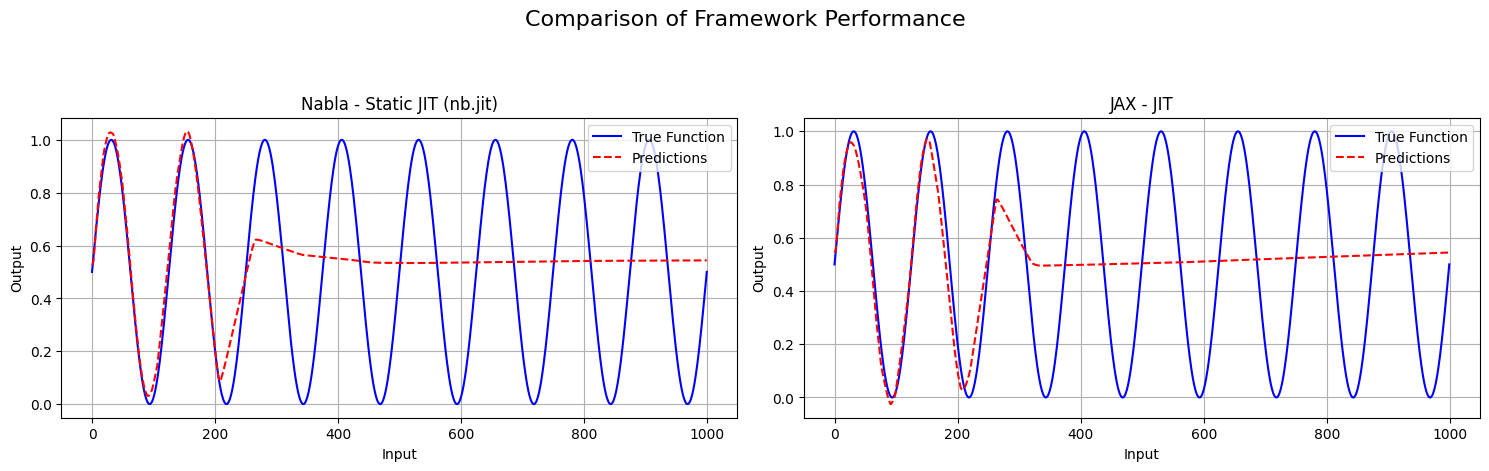


                                            FRAMEWORK PERFORMANCE COMPARISON                                            
Framework       | Mode                      | Total Time (s)  | Avg Epoch Time (ms)  | Final Loss   | Correlation 
------------------------------------------------------------------------------------------------------------------------
Nabla           | Static JIT (nb.jit)       | 11.0393         | 10.3801              | 0.094859     | 0.5083      
JAX             | JIT                       | 16.7909         | 16.4544              | 0.091569     | 0.5198      

                                                        SUMMARY                                                         
Lowest final loss: JAX - JIT (Loss: 0.091569)
Highest correlation: JAX - JIT (Correlation: 0.5198)
Fastest average epoch time: Nabla - Static JIT (nb.jit) (10.3801 ms)


In [7]:
# Run experiments
results = []

# Run Nabla experiments
# print("\nRunning Nabla Eager Mode Experiment...")
# results.append(run_nabla_experiment(nb_train_step_no_jit, "Eager Mode (No JIT)"))

# print("\nRunning Nabla Dynamic JIT Experiment...")
# results.append(run_nabla_experiment(nb_train_step_djit, "Dynamic JIT (nb.djit)"))

print("\nRunning Nabla Static JIT Experiment...")
results.append(run_nabla_experiment(nb_train_step_jit, "Static JIT (nb.jit)"))

# Run JAX experiments
# print("\nRunning JAX Eager Mode Experiment...")
# results.append(run_jax_experiment(jax_train_step_no_jit, "Eager Mode (No JIT)"))

print("\nRunning JAX JIT Experiment...")
results.append(run_jax_experiment(jax_train_step_jit, "JIT"))

# Plot comparison of predictions
plt.figure(figsize=(15, 12))
plt.suptitle("Comparison of Framework Performance", fontsize=16)

for i, res in enumerate(results, 1):
    plt.subplot(3, 2, i)
    plt.plot(res["targets"], label="True Function", color="blue")
    plt.plot(res["predictions"], label="Predictions", color="red", linestyle="--")
    plt.title(f"{res['framework']} - {res['mode']}")
    plt.xlabel("Input")
    plt.ylabel("Output")
    plt.legend()
    plt.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Display results comparison table
print("\n" + "=" * 120)
print("FRAMEWORK PERFORMANCE COMPARISON".center(120))
print("=" * 120)
print(
    f"{'Framework':<15} | {'Mode':<25} | {'Total Time (s)':<15} | {'Avg Epoch Time (ms)':<20} | {'Final Loss':<12} | {'Correlation':<12}"
)
print("-" * 120)

for res in results:
    print(
        f"{res['framework']:<15} | {res['mode']:<25} | {res['total_time']:<15.4f} | {res['avg_epoch_time'] * 1000:<20.4f} | {res['final_loss']:<12.6f} | {res['correlation']:<12.4f}"
    )

# Find best performance
best_loss = min(results, key=lambda x: x["final_loss"])
best_corr = max(results, key=lambda x: x["correlation"])
fastest = min(results, key=lambda x: x["avg_epoch_time"])

print("\n" + "=" * 120)
print("SUMMARY".center(120))
print("=" * 120)
print(
    f"Lowest final loss: {best_loss['framework']} - {best_loss['mode']} (Loss: {best_loss['final_loss']:.6f})"
)
print(
    f"Highest correlation: {best_corr['framework']} - {best_corr['mode']} (Correlation: {best_corr['correlation']:.4f})"
)
print(
    f"Fastest average epoch time: {fastest['framework']} - {fastest['mode']} ({fastest['avg_epoch_time'] * 1000:.4f} ms)"
)